In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
%matplotlib inline

### Downloading and loading the dataset

This dataset contains numerical data, and thus our decision tree is only meant to deal with numerical data. We can further make it work for categorical features.

In [2]:
# Credits to ritvik and his YouTube channel ritvikmath for the dataset

fish_dataset_url = "https://raw.githubusercontent.com/ritvikmath/YouTubeVideoCode/main/fish.csv"

# We can access the content (csv file) from the github repository with the help of the requests.get() function
res = requests.get(fish_dataset_url, allow_redirects = True)

# We then write the content of the requested object into a csv file named fish_dataset which will get created if there isn't a file with this name
with open('fish_dataset.csv', 'wb') as file:
    file.write(res.content)
    
fish_df = pd.read_csv('fish_dataset.csv')

In [3]:
# Converting the type (which is in 'tuna' and 'salmon') into numerical values (1 and 0)
fish_df.type = fish_df.type.apply(lambda x: 1 if x == 'tuna' else 0)

### Visualizing the data on a 2-D plot

Text(0, 0.5, 'Weight')

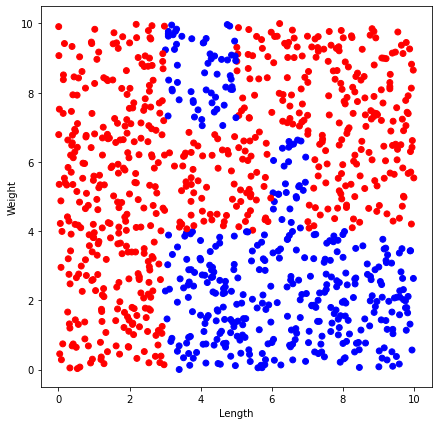

In [4]:
plt.figure(figsize=(7, 7))
plt.scatter(fish_df.length, fish_df.weight, color=['red' if t == 1 else 'blue' for t in fish_df.type], s=35)
plt.xlabel('Length')
plt.ylabel('Weight')

In [5]:
fish_df.head()

,length,weight,type
0,8.618381,7.848030,1
1,2.522046,8.762507,1
2,2.035690,7.101971,1
3,6.695008,4.953932,0
4,9.834069,7.908453,1


### Our very own DecisionTreeClassifier implementation

In [6]:
class DecisionTreeClassifier:
    def __init__(self, max_depth = 3, min_samples_split = 2, best_params = {}, split_bounds = [], entropy_threshold = 1e-1):
        # The meaning of the parameters can be better understood from sklearn's official documentation on Decision Tree Classifiers
        # documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.best_params = best_params
        self.entropy_threshold = entropy_threshold
        self.split_bounds = split_bounds

    def __get_entropy(self, data):
        values = data.iloc[:, -1]
        if len(values) == 0:
            return 0
        unique, counts = np.unique(values, return_counts = True)
        
        prob = counts / counts.sum()
        entropy = -sum(prob * np.log2(prob))
        
        return entropy
    
    def __get_entropy_from_split(self, df, feature, split_val):
        # Get the split dataframes based on the split value for the splitting feature
        left_data = df[df[feature] < split_val]
        right_data = df[df[feature] >= split_val]
        
        # Our task is to find the weighted entropy of the split dataframe
        prob_left = len(left_data)/len(df)
        prob_right = len(right_data)/len(df)
        
        left_entropy = self.__get_entropy(left_data)
        right_entropy = self.__get_entropy(right_data)
        
        weighted_entropy = (left_entropy * prob_left) + (right_entropy * prob_right)
        return weighted_entropy
        
    def train(self, df, step_value = 0.02):
        # Checking the base condition of depth of the tree
        if(self.max_depth <= 0):
            return

        # Temporary variables for checking whether we got a split in the current dataframe or not and for updating the best parameters accordingly
        best_feature = ""
        best_value = np.inf
        best_entropy = self.__get_entropy(df)

        for f in df.columns[:-1]:
            # We will start from the minumum value of the feature f and increment it by some value, each time checking if splitting it at that value gives us less entropy (randomness)
            curr = df[f].min()
            while curr < df[f].max():
                curr_entropy = self.__get_entropy_from_split(df, f, curr)
                if curr_entropy < best_entropy:
                    best_entropy = curr_entropy
                    best_feature = f
                    best_value = curr
                curr += step_value
        
        # Checking if we were able to get a better split by comparing the entropy achieved with that of the unsplit dataframe
        if(best_feature == ""):
            return

        # Updating the best_param_values
        self.best_params["feature"].append(best_feature)
        self.best_params["value"].append(best_value)
        self.best_params["entropy"].append(best_entropy)
        
        self.split_bounds.append([(df.iloc[:, 0].min(), df.iloc[:, 0].max()), (df.iloc[:, 1].min(), df.iloc[:, 1].max())])

        # print("Feature =", self.best_params['feature'][-1])
        # print("Value =", self.best_params['value'][-1])
        # print("Entropy =", self.best_params['entropy'][-1])
        
        # Getting the split dataframes
        left_df = df[df[self.best_params['feature'][-1]] < self.best_params['value'][-1]]
        right_df = df[df[self.best_params['feature'][-1]] >= self.best_params['value'][-1]]

        # Getting their entropies for comparing with the entropy threshold
        left_entropy = self.__get_entropy(left_df)
        right_entropy = self.__get_entropy(right_df)

        # print("left_entropy =", left_entropy)
        # print("right_entropy =", right_entropy)
        
        self.max_depth -= 1

        if right_entropy > self.entropy_threshold and len(right_df) >= self.min_samples_split:
            return self.train(df = right_df)
        if left_entropy > self.entropy_threshold and len(left_df) >= self.min_samples_split:
            return self.train(df = left_df)
        
        return
                        
        
    
    def plot_decision_tree(self, df):
        '''Plot the Decision Tree boundaries on a 2-D plot. This method should and can only be used for datasets having 2 features'''
        features = list(df.columns[:-1])
        
        plt.figure(figsize=(7, 7))
        plt.scatter(fish_df[features[0]], fish_df[features[1]], color=['red' if t == 1 else 'blue' for t in fish_df.type], s=35)
        plt.xlabel(f"{features[0]}")
        plt.ylabel(f"{features[1]}")

        for i in df.columns[:-1]:
            for j in range(len(self.best_params['entropy'])):
                feature = self.best_params['feature'][j]
                value = self.best_params['value'][j]
                if feature == i:
                    bbox = self.split_bounds[j]
                    left_df, right_df = df[df[feature] < value], df[df[feature] >= value]
                    x_min, x_max, y_min, y_max = df.iloc[:, 0].min(), df.iloc[:, 0].max(), df.iloc[:, 1].min(), df.iloc[:, 1].max()
                    if i == features[0]:
                        val = left_df[features[0]].max()
                        plt.plot(np.linspace(val, val, 100), np.linspace(bbox[1][0], bbox[1][1], 100), c='black', linewidth=3)
                        
                    elif i == features[1]:
                        val = left_df[features[1]].max()
                        plt.plot(np.linspace(bbox[0][0], bbox[0][1], 100), np.linspace(val, val, 100), c = 'black', linewidth = 3)
                        
        plt.show()


In [7]:
best_param_values = {'feature': [], 'value': [], 'entropy': []}
split_bounds = []
decision_tree = DecisionTreeClassifier(max_depth = 5, min_samples_split = 4, best_params=best_param_values, split_bounds=split_bounds)
decision_tree.train(fish_df)

In [8]:
best_param_values
# split_bounds


{'feature': ['length', 'weight', 'length', 'length', 'weight'],
 'value': [2.9865456626365487,
  4.001260199577321,
  6.968879131610861,
  5.008879131610903,
  6.645588309292261],
 'entropy': [0.6843553171032571,
  0.426763555582736,
  0.5487969419888971,
  0.8954692060203256,
  0.4998889836059453]}

### Visulization of our model's performance

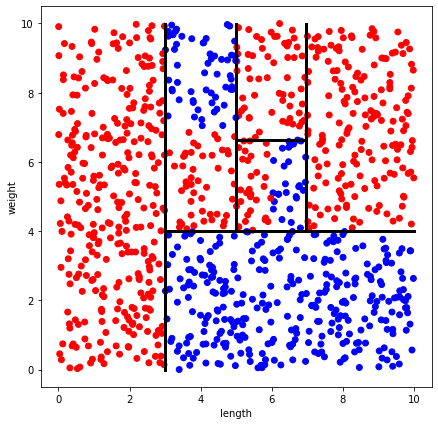

In [9]:
decision_tree.plot_decision_tree(fish_df)

### Scikit-Learn's Implementation of DecisionTreeClassifier on our Dataset

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
model = DecisionTreeClassifier(max_depth = 5, min_samples_split = 4, criterion="entropy")
model.fit(fish_df.iloc[:, :-1], fish_df.iloc[:, -1])

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=4)

In [12]:
from sklearn.tree import plot_tree

### Comparing Scikit-Learn's model with our implementation

{'feature': ['length', 'weight', 'length', 'length', 'weight'], 'value': [2.9865456626365487, 4.001260199577321, 6.968879131610861, 5.008879131610903, 6.645588309292261], 'entropy': [0.6843553171032571, 0.426763555582736, 0.5487969419888971, 0.8954692060203256, 0.4998889836059453]}


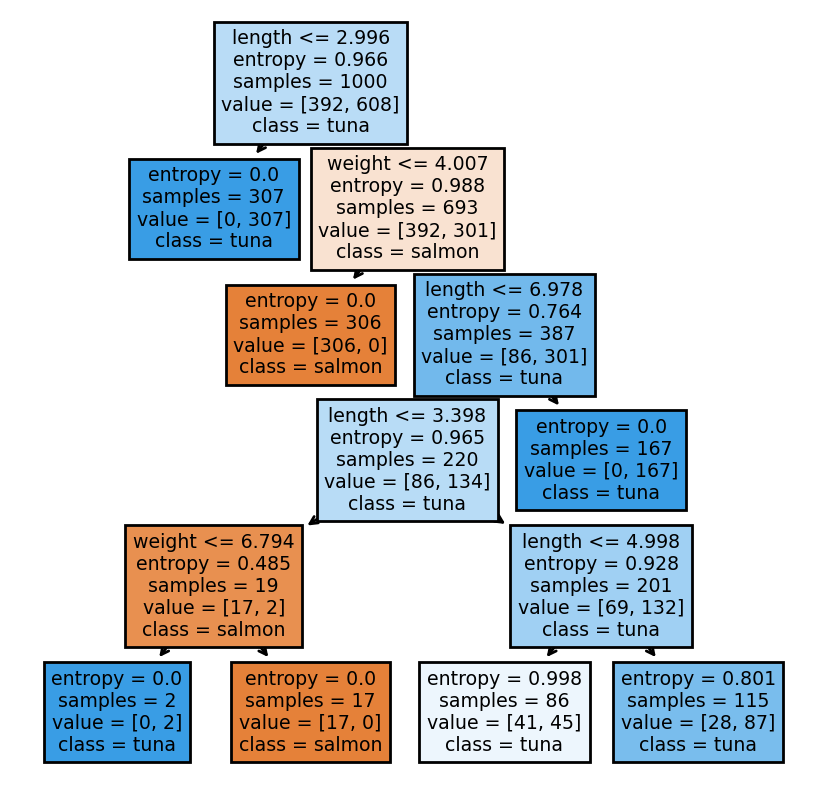

In [13]:
fn=['length','weight']
cn=['salmon', 'tuna']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=200)
plot_tree(model,
               feature_names = fn, 
               class_names=cn,
               filled = True);

print(best_param_values)

### On comparing our model with sklearn's implementation of DecisionTreeClassifer, we can see that the splits are very similar and differ only by the order of $10^{-2}$ or $0.01$ which confirms the correctness of our implementation
